In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from bmark.utils.config import load_config
from bmark.utils.analysis import order_cat,get_scores,plot_confidence, plot_confusion, plot_cluster_scores

sns.set()

In [2]:
paths = load_config()['pilot']
ad = sc.read_h5ad(paths['data_dir']/'consolidated.h5ad')
obs = ad.obs.copy()

# order of categorical labels for plotting convenience
_, cluster_count_order = order_cat(obs, cat='cluster', by='count')
_, cluster_id_order = order_cat(obs, cat='cluster', by='id')

_, subclass_count_order = order_cat(obs, cat='subclass', by='count')
_, subclass_id_order = order_cat(obs, cat='subclass', by='id')

In [3]:
# Load scANVI results:
obs = ad.obs.copy()
tmp = pd.read_csv(paths['result_dir'] / "mlp_scANVI.csv", index_col=0)
tmp = tmp.loc[obs.index,:]
tmp.drop(["fold"], axis=1, inplace=True)
obs = pd.concat([obs, tmp], axis=1)
obs["correct_scANVI"] = obs["cluster_label"] == obs["cluster_label_scANVI"]

df_scanvi = obs[['cluster_label','cluster_label_scANVI','cluster_label_conf_scANVI']].copy()
df_scanvi.columns=['true','pred','conf']
df_scanvi['true'] = df_scanvi['true'].astype(cluster_count_order)

In [4]:
# load mlp_nsf results:
obs = ad.obs.copy()
tmp = pd.read_csv(paths['result_dir'] / "mlp_nsforest.csv", index_col=0)
tmp = tmp.loc[obs.index,:]
obs = pd.concat([obs, tmp], axis=1)
obs["correct_0"] = obs["cluster_label"] == obs["cluster_label_0"]

df_mlp = obs[['cluster_label','cluster_label_0','cluster_conf_0']].copy()
df_mlp.columns=['true','pred','conf']
df_mlp['true'] = df_mlp['true'].astype(cluster_count_order)

### `mlp_nsf` results

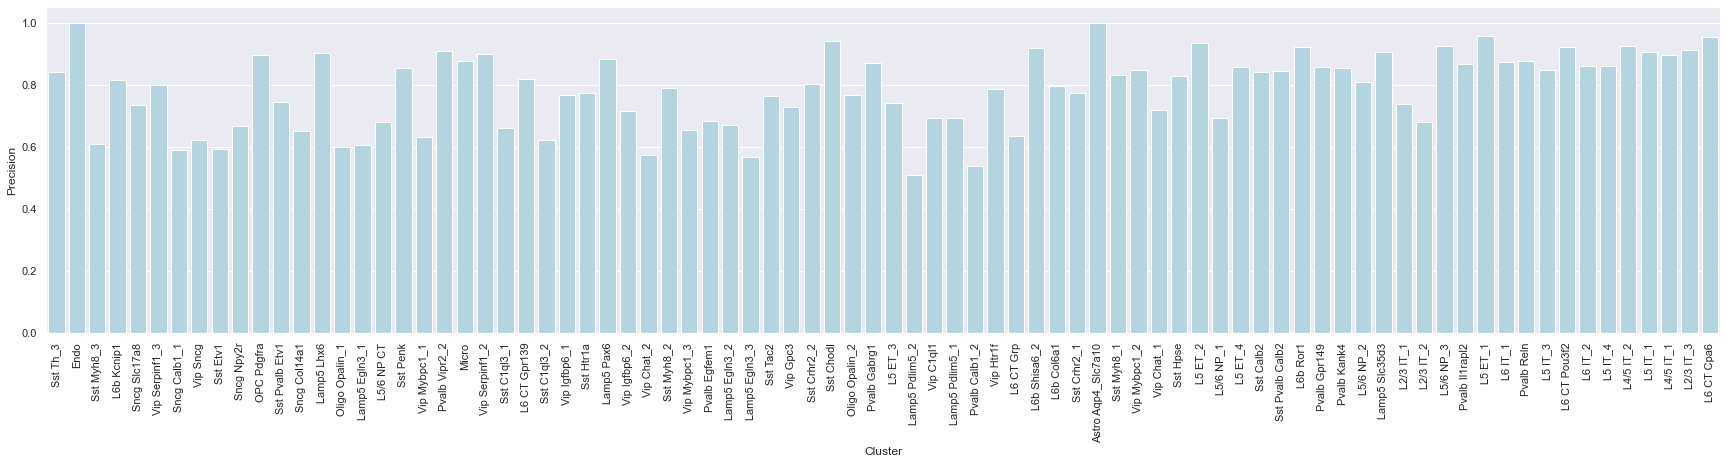

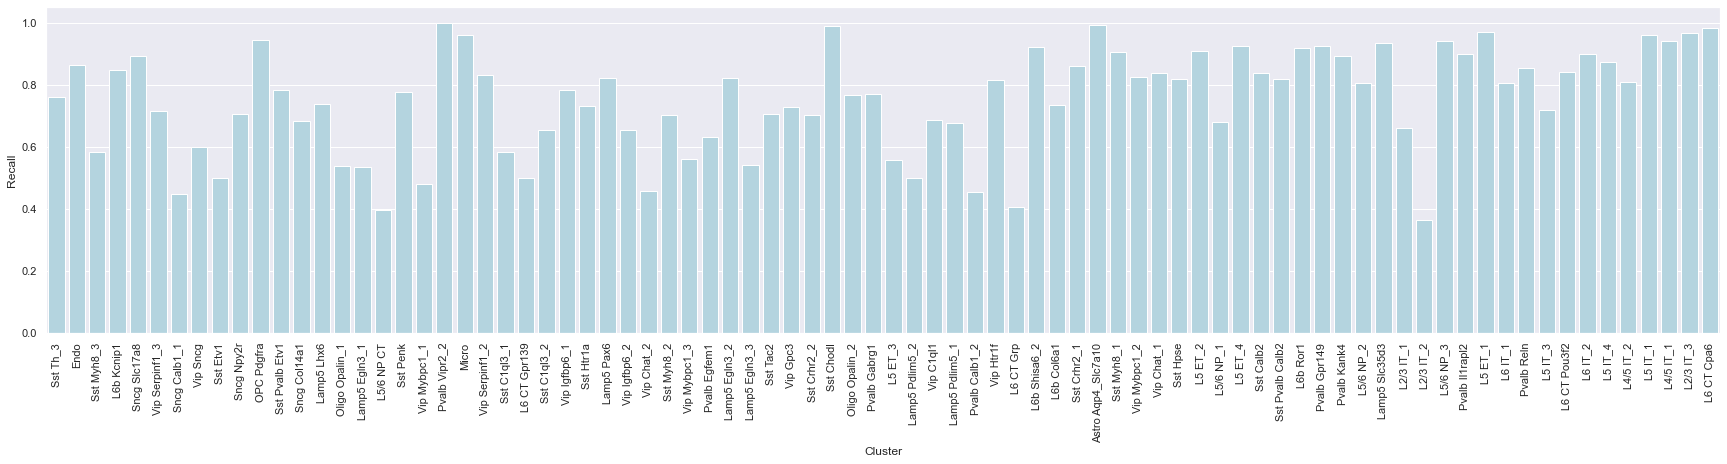

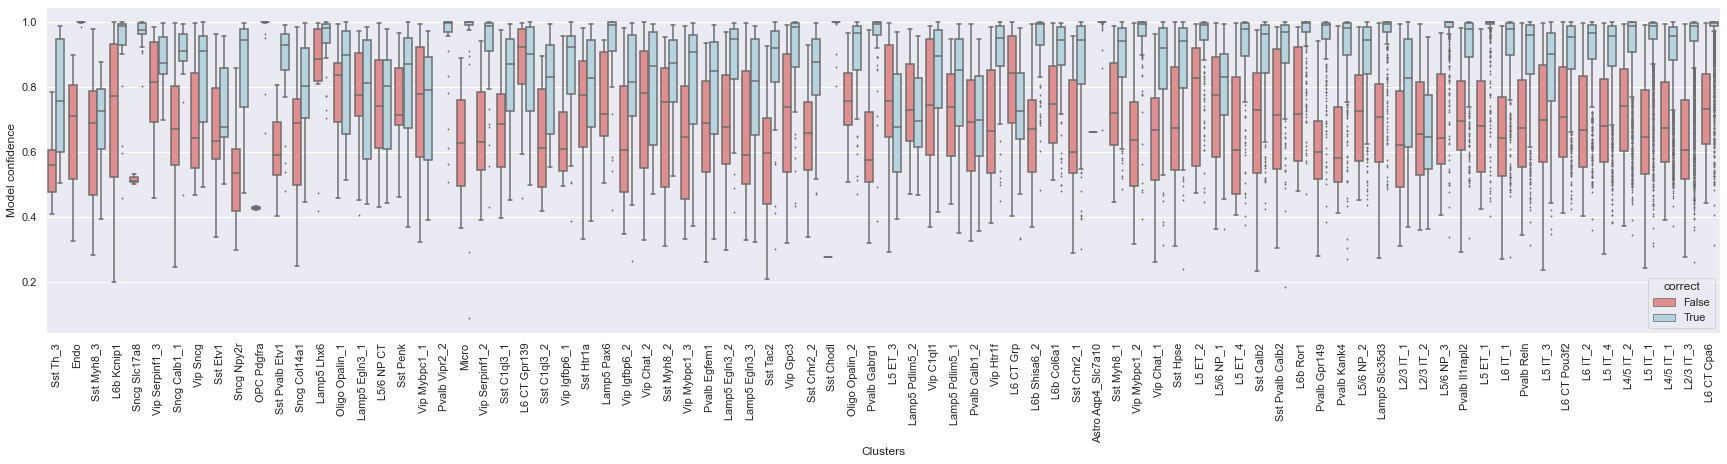

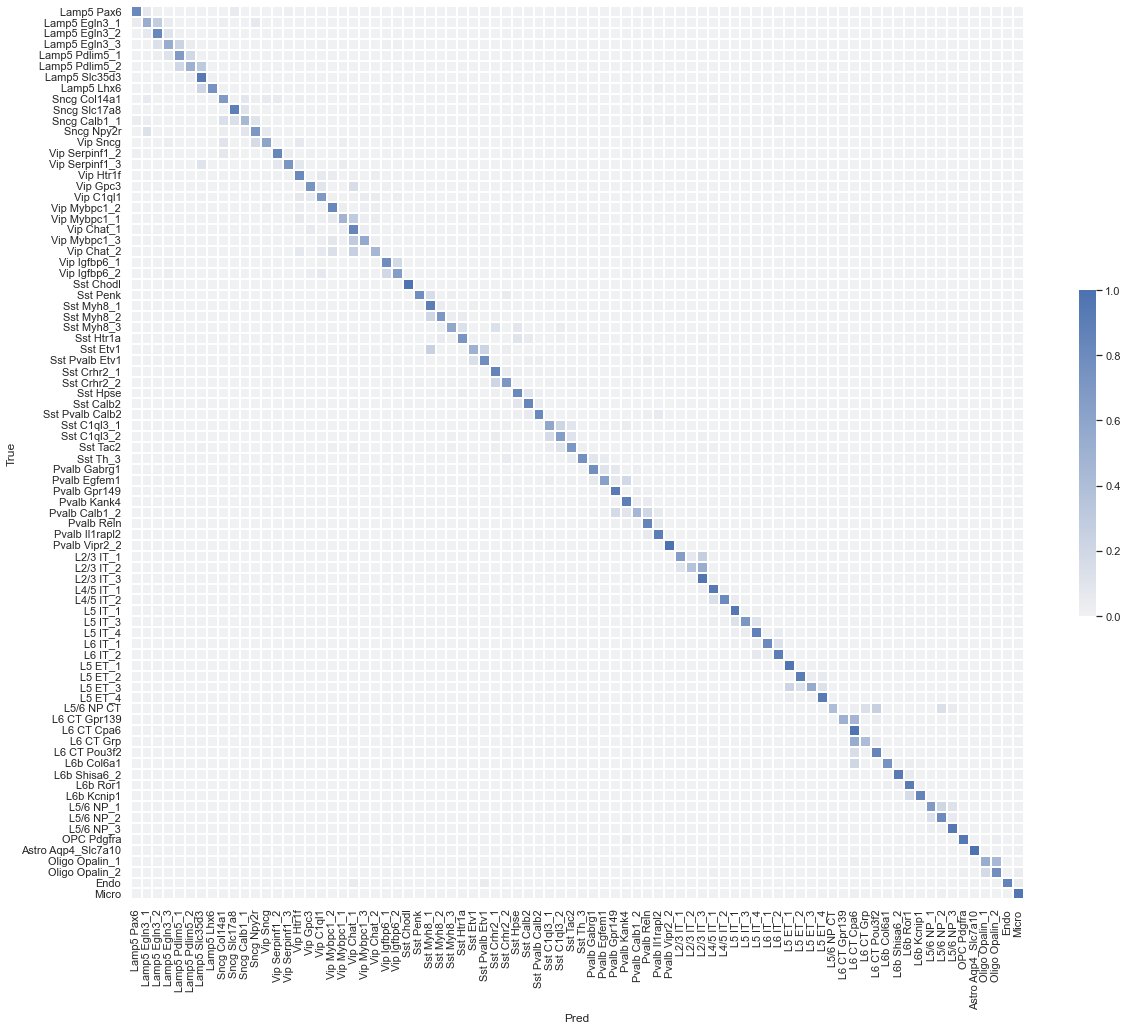

In [5]:
df_mlp['true'] = df_mlp['true'].astype(cluster_count_order)
result_mlp = get_scores(df=df_mlp)
plot_cluster_scores(df=result_mlp)
plot_confidence(df=df_mlp)

df_mlp['true'] = df_mlp['true'].astype(cluster_id_order)
_ = plot_confusion(df=df_mlp, figsize=(20,20))


### `scANVI` results

/Users/fruity/miniconda3/envs/ctype/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


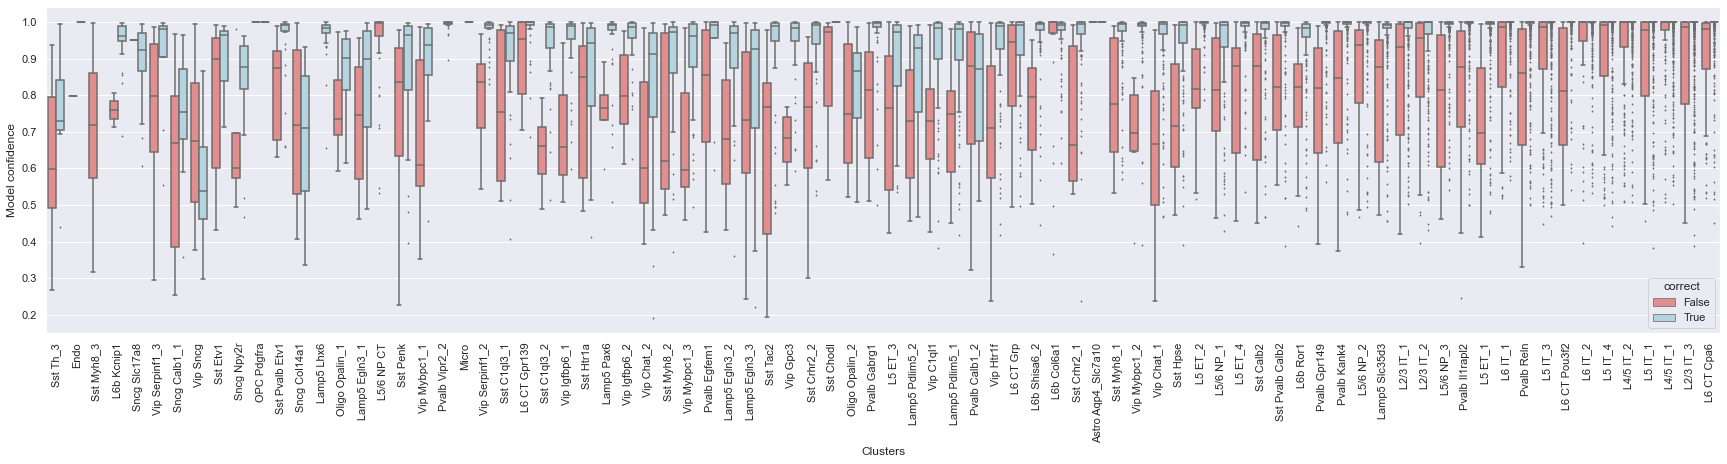

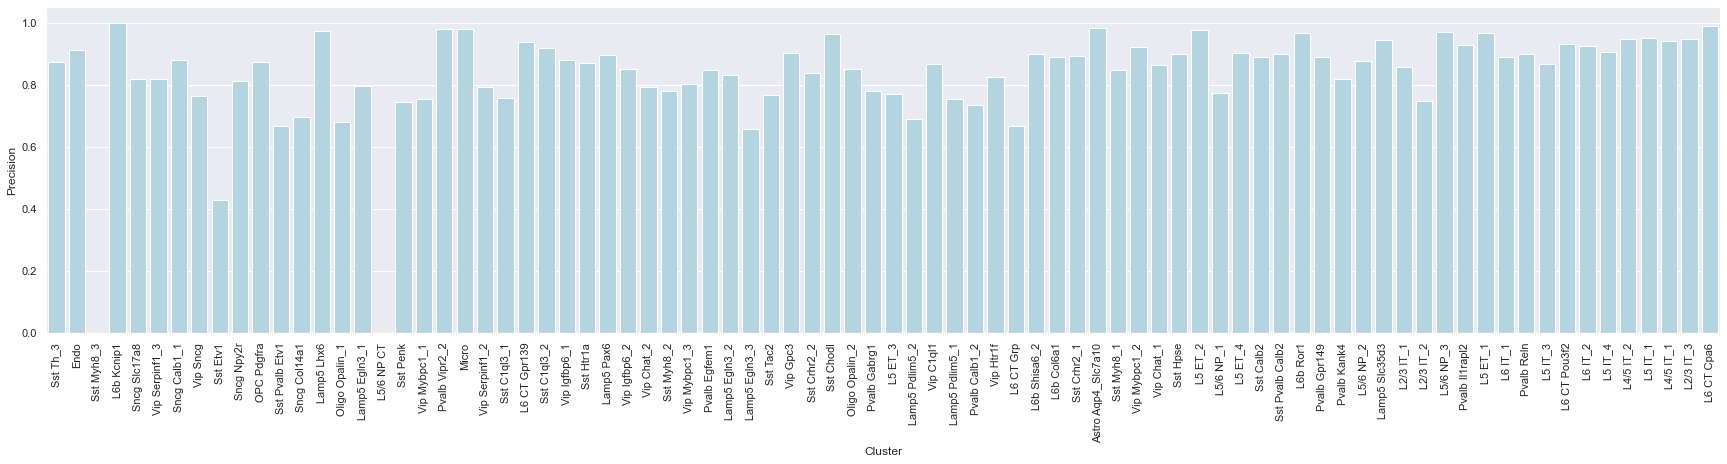

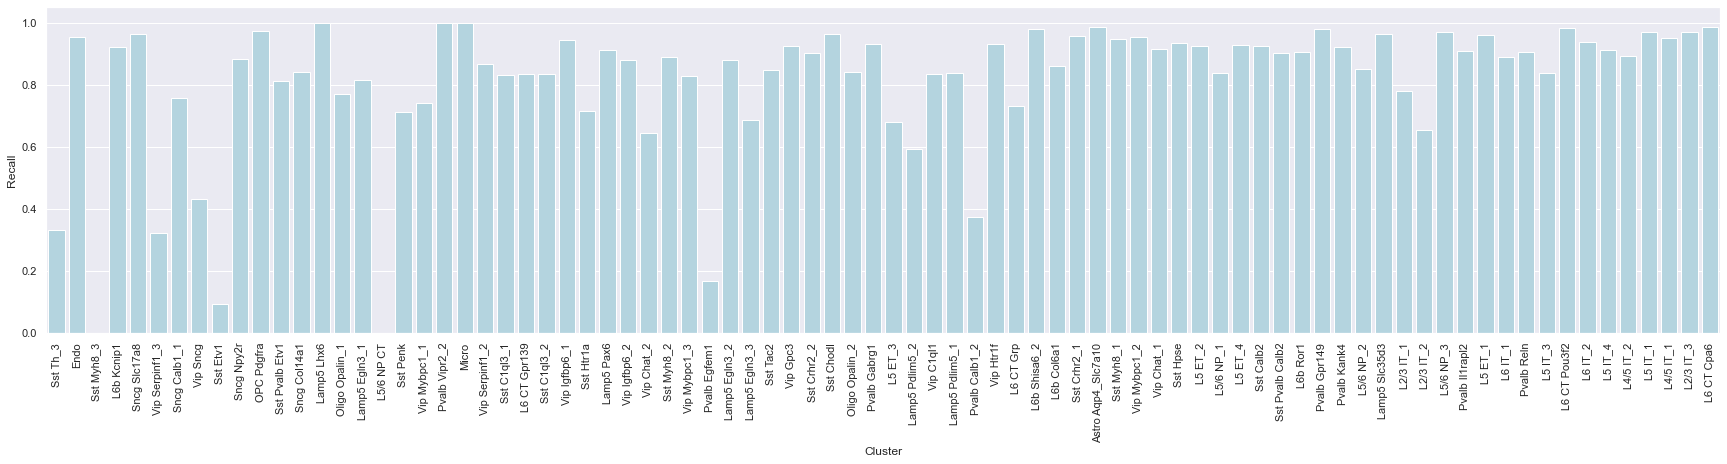

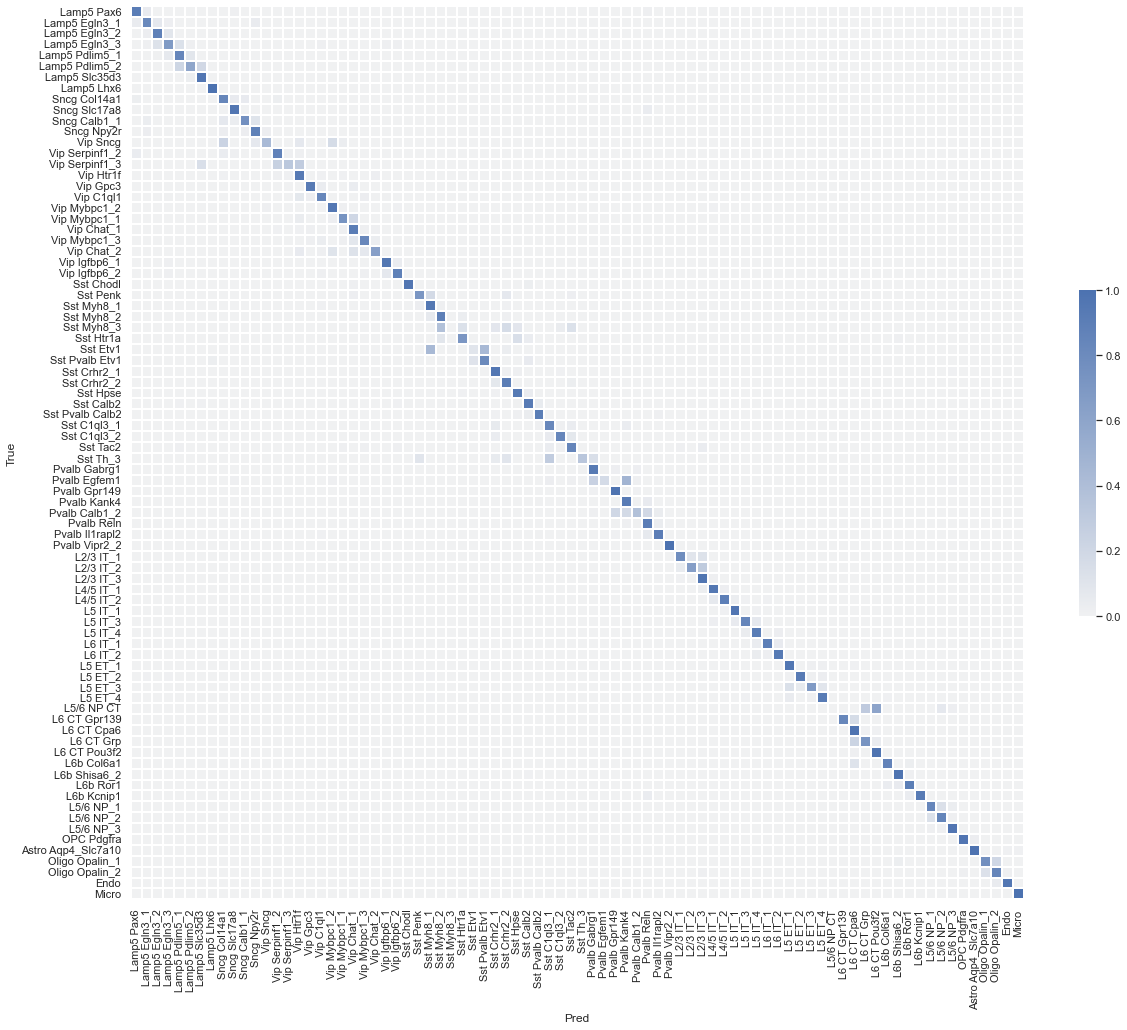

In [6]:
df_scanvi['true'] = df_scanvi['true'].astype(cluster_count_order)
result_scanvi = get_scores(df=df_scanvi)
plot_confidence(df=df_scanvi)
plot_cluster_scores(result_scanvi)

df_scanvi['true'] = df_scanvi['true'].astype(cluster_id_order)
_ = plot_confusion(df=df_scanvi, figsize=(20,20))

### Comparisons: `mlp_nsf` vs `scANVI`

In [7]:
df = result_mlp.merge(result_scanvi, how='left', left_on='label', right_on='label', suffixes=['_mlp', '_scanvi'])

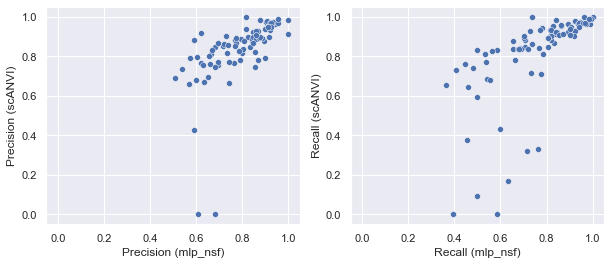

In [8]:
f,ax = plt.subplots(1,2,figsize=(10,4))
sns.scatterplot(x=df['precision_mlp'], y=df['precision_scanvi'], ax=ax[0])
ax[0].set(xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
       xlabel='Precision (mlp_nsf)',
       ylabel='Precision (scANVI)')

sns.scatterplot(x=df['recall_mlp'], y=df['recall_scanvi'], ax=ax[1])
ax[1].set(xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
       xlabel='Recall (mlp_nsf)',
       ylabel='Recall (scANVI)')
plt.show()